Steps for data science project:
- understand of business problem;
- formalize problem;
- collect data;
- visualize data;
- preprocess data;
- model data;
- evaluate model;
- deploy model.

Useful functions:
* [shift](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.shift.html)
* [resample](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.resample.html), see list of [aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
* [nlargest](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.Series.nlargest.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
features = pd.read_pickle('features.pkl')
features_cols_list = features.columns.tolist()
target = pd.read_pickle('target.pkl')

In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14208 entries, 2019-01-08 00:00:00+00:00 to 2019-10-30 23:30:00+00:00
Freq: 30T
Data columns (total 3 columns):
0    14122 non-null object
1    14122 non-null object
2    14122 non-null object
dtypes: object(3)
memory usage: 444.0+ KB


In [4]:
features.sample(5)

,0,1,2
2019-03-23 05:00:00+00:00,1.04794,0.739947,0.994831
2019-04-18 17:30:00+00:00,1.60394,1.53386,1.70063
2019-02-10 18:30:00+00:00,2.38767,2.52444,2.11415
2019-02-01 19:30:00+00:00,1.16325,1.56663,1.5166
2019-02-09 10:30:00+00:00,2.72602,2.8165,2.78639


In [5]:
for col in features.columns:
    features[col] = features[col].astype(np.float64)

In [6]:
features['target'] = target

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14208 entries, 2019-01-08 00:00:00+00:00 to 2019-10-30 23:30:00+00:00
Freq: 30T
Data columns (total 4 columns):
0         14122 non-null float64
1         14122 non-null float64
2         14122 non-null float64
target    14208 non-null float64
dtypes: float64(4)
memory usage: 555.0 KB


In [8]:
del target

In [9]:
features['dt'] = features.index

In [10]:
features.reset_index(inplace=True, drop=True)

In [11]:
features.head()

,0,1,2,target,dt
0,2.778776,2.795029,2.550405,2.857432,2019-01-08 00:00:00+00:00
1,2.795336,2.778668,2.550405,2.868542,2019-01-08 00:30:00+00:00
2,2.806959,2.761620,2.550405,2.832536,2019-01-08 01:00:00+00:00
3,2.810723,2.762358,2.552570,2.874722,2019-01-08 01:30:00+00:00
4,2.814365,2.775047,2.554735,2.874747,2019-01-08 02:00:00+00:00


In [12]:
Counter(features.dt-features.dt.shift(1))

Counter({NaT: 1, Timedelta('0 days 00:30:00'): 14207})

In [13]:
(features.dt-features.dt.shift(1)).values.tolist().count(1800000000000) == features.shape[0]-1

True

In [14]:
# std for column 1 is 
features.describe()

,0,1,2,target
count,14122.000000,14122.000000,14122.000000,14208.000000
mean,1.469693,1.380626,1.557116,1.478365
std,1.002067,1.056903,1.001082,1.000035
min,-0.006671,0.000000,0.035723,-0.029981
25%,0.588703,0.438246,0.679008,0.587263
50%,1.331916,1.245316,1.430002,1.351276
75%,2.311821,2.248821,2.377203,2.355788
max,4.980764,4.729050,4.343178,3.773450


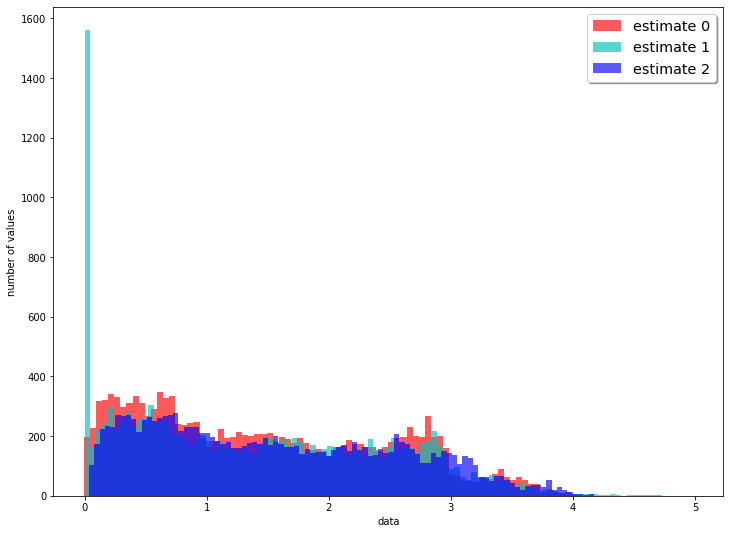

In [15]:
plt.figure(figsize=(12,9))
fig_opacity = 0.65
num_bins = 100

colors_list = ['r', 'c', 'b']
for num_estimate in range(3):
    plt.hist(features[num_estimate], 
             bins=num_bins, 
             color=colors_list[num_estimate], 
             alpha=fig_opacity, 
             label='estimate {num_est}'.format(num_est=num_estimate))

legend = plt.legend(shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('white')
plt.xlabel('data')
plt.ylabel('number of values')

plt.show()

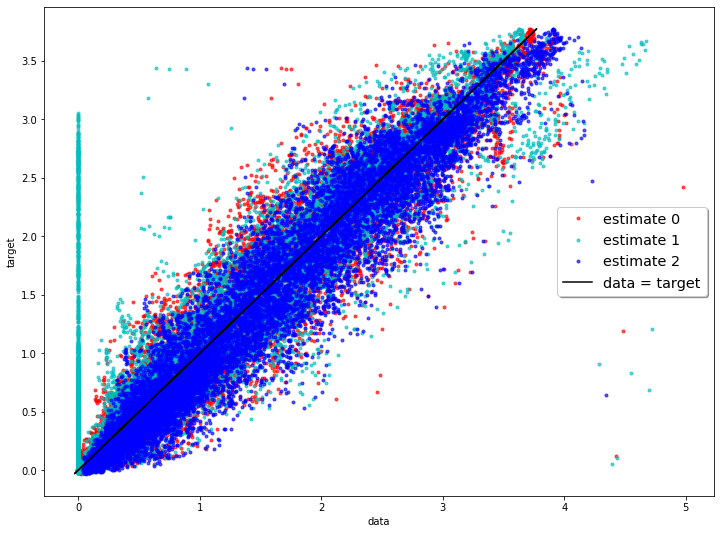

In [16]:
plt.figure(figsize=(12,9))
fig_opacity = 0.65

colors_list = ['r', 'c', 'b']
for num_estimate in range(3):
    plt.plot(features[num_estimate],
             features['target'],
             '{c}.'.format(c=colors_list[num_estimate]),
             alpha=fig_opacity,
             label='estimate {num_est}'.format(num_est=num_estimate))
plt.plot(features['target'], features['target'], label='data = target', c='black')

legend = plt.legend(shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('white')
plt.xlabel('data')
plt.ylabel('target')

plt.show()

clearly, zero values in est.1 are the converted NaNs

In [17]:
# look on NaN values
features_nan = features[features[0].isnull()].copy()

In [18]:
features_nan

,0,1,2,target,dt
9269,NaN,NaN,NaN,1.766581,2019-07-20 02:30:00+00:00
9273,NaN,NaN,NaN,1.407293,2019-07-20 04:30:00+00:00
9275,NaN,NaN,NaN,1.494137,2019-07-20 05:30:00+00:00
9277,NaN,NaN,NaN,1.274611,2019-07-20 06:30:00+00:00
9279,NaN,NaN,NaN,1.234772,2019-07-20 07:30:00+00:00
9284,NaN,NaN,NaN,2.402506,2019-07-20 10:00:00+00:00
9288,NaN,NaN,NaN,2.547267,2019-07-20 12:00:00+00:00
9290,NaN,NaN,NaN,2.378109,2019-07-20 13:00:00+00:00
9295,NaN,NaN,NaN,1.530843,2019-07-20 15:30:00+00:00
9297,NaN,NaN,NaN,1.380863,2019-07-20 16:30:00+00:00


### check whether there are subsequent equal values (may also be the indication for NaNs, e.g. filled forward)

In [52]:
for col in range(3):
    df = features[col]-features[col].shift(1)
    print(col, df.values.tolist().count(0))

0 1
1 0
2 170


In [19]:
feature_index_array = np.array(features_nan.index)
feature_index_array[1:]-feature_index_array[:-1]

array([ 4,  2,  2,  2,  5,  4,  2,  5,  2,  3,  5,  1,  6,  6, 18,  3, 18,
        2,  7,  5, 14, 11,  2,  4, 10,  2,  5,  7,  8,  1,  1, 17,  1,  1,
        8,  4,  8,  7,  2,  3,  8,  5,  4,  1,  8, 11,  4,  2,  1,  6,  2,
        2,  6,  1,  1,  2,  8,  2,  1,  8,  2, 11,  1,  1,  3,  5,  1,  5,
       12, 13,  4,  2,  2,  3,  8,  5,  3,  5,  5,  2,  4, 17,  1,  1,  5],
      dtype=int64)

In [20]:
# fill nans for all columns using the model trained on previous data

In [21]:
features.dt.head().apply(lambda x: 60*x.hour+x.minute)

0      0
1     30
2     60
3     90
4    120
Name: dt, dtype: int64

In [22]:
model = xgb.XGBRegressor(objective='reg:squarederror')

In [23]:
features.sample(5)

,0,1,2,target,dt
9968,0.079207,0.092975,0.128819,0.115845,2019-08-03 16:00:00+00:00
2010,2.515343,2.597312,2.622934,2.751744,2019-02-18 21:00:00+00:00
3266,2.857644,2.801235,2.963926,2.738452,2019-03-17 01:00:00+00:00
12155,0.464300,0.596658,0.792401,0.549649,2019-09-18 05:30:00+00:00
2206,2.222995,2.301194,2.386946,2.390371,2019-02-22 23:00:00+00:00


In [24]:
# add month as feature
features['month'] = features['dt'].apply(lambda x: x.month)

In [26]:
def fit_error(features):
    mae_train_list = []
    mae_val_list = []
    month_list = features.month.unique().tolist()
    for month in month_list[1:]:
        features_train = features[features.month < month]
        features_val = features[features.month == month]
        y_train = features_train['target'].copy()
        X_train = features_train.drop(['target', 'dt', 'month'], axis=1).copy()
        y_val = features_val['target'].copy()
        X_val = features_val.drop(['target', 'dt', 'month'], axis=1).copy()
        model = xgb.XGBRegressor(objective='reg:squarederror')
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        mae_train_list.append(mae_train)
        mae_val_list.append(mae_val)
    print('>>> mean MAE train and val errors')
    print(np.mean(mae_train_list), np.mean(mae_val_list))
    return None

In [27]:
fit_error(features)

>>> mean MAE train and val errors
0.15552640831147957 0.22892115097245577


In [28]:
# convert 0s to NaNs and retrain again
features.loc[features[1] == 0, 1] = np.nan

In [29]:
fit_error(features)

>>> mean MAE train and val errors
0.15520846728785237 0.22839144045757395


In [30]:
# add minute as feature
features['minute'] = features['dt'].apply(lambda x: 60*x.hour+x.minute)

In [31]:
fit_error(features)

>>> mean MAE train and val errors
0.15363077983351411 0.2301488814098836


In [32]:
# add week of the year as feature
features['week'] = features['dt'].apply(lambda x: x.isocalendar()[1])

In [33]:
fit_error(features)

>>> mean MAE train and val errors
0.14764846068809057 0.24140064847610943


In [34]:
# add day of the year as feature
features['day'] = features['dt'].apply(lambda x: 7*(x.isocalendar()[1]-1)+x.isocalendar()[2]-1)

In [35]:
fit_error(features)

>>> mean MAE train and val errors
0.13860008948722585 0.26922285479657276


In [36]:
#xgb.plot_importance(model)